In [1]:
import pandas as pd
import numpy as np
from random import choice

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator

import re
import nltk
from rake_nltk import Rake
#nltk.download('stopwords')

import lda
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
apple_grossing1 = pd.read_json('applestore_paid_1.json')
apple_grossing2 = pd.read_json('applestore_paid_2.json')

In [3]:
col_n = ['category', 'description', 'reviews', 'subtitle', 'title']
apple_grossing = pd.DataFrame(apple_grossing1,columns = col_n)
apple_grossing.append(pd.DataFrame(apple_grossing2,columns = col_n))
apple_grossing.head()

,category,description,reviews,subtitle,title
0,Games,"Cats and pandas are available right meow, for ...",|This game has been my favorite game for a few...,"Create, explore and survive!",Minecraft
1,Games,"It's the game The New York Times called a ""Sen...","|I love playing this game with my friends, but...",Trivia on the go,Heads Up!
2,Education,Instantly identify plants of all kinds: flower...,"|What a wonderful app, and a wonderful concept...",Identify a Flower Leaf or Tree,PlantSnap Plant Identification
3,Games,Can you infect the world? Plague Inc. is a uni...,|I'm a fairly new player to Plague Inc. I hav...,Can you Infect the World?,Plague Inc.
4,Medical,"Join millions of medical professionals, studen...",|I was hesitant to buy this app given how much...,Complete 3D Human Body,Human Anatomy Atlas 2019


In [4]:
clean_reviews = lambda x: x.replace('|', ' ')
apple_grossing['reviews'] = apple_grossing['reviews'].map(clean_reviews)
clean_subtitle = lambda x: x.replace('N/A', '')
apple_grossing['subtitle'] = apple_grossing['subtitle'].map(clean_subtitle)
apple_grossing.dropna()

apple_reviews = apple_grossing['reviews'].tolist()
apple_subtitle = apple_grossing['subtitle'].tolist()
apple_description = apple_grossing['description'].tolist()
apple_category = apple_grossing['category'].tolist()
apple_title = apple_grossing['title'].tolist()

apple_grossing['category'].unique()

array(['Games', 'Education', 'Medical', 'Photo & Video', 'Reference',
       'Weather', 'Business', 'Productivity', 'Health & Fitness',
       'Sports', 'Music', 'Entertainment', 'Utilities', 'Lifestyle',
       'Navigation'], dtype=object)

In [5]:
def my_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return choice(["rgb(94,38,18)", "rgb(41,36,33)", "rgb(128,128,105)", "rgb(112,128,105)"])

def draw_cloud(word_freq):  
    wc = WordCloud(background_color="white",  
                   max_words=800,  
                   max_font_size=80, 
                   random_state=42,
                   )

    wc.generate_from_frequencies(word_freq)

    plt.figure(figsize=(12,12))

    plt.imshow(wc.recolor(color_func=my_color_func), interpolation='bilinear')

    plt.axis("off")
    plt.show()

In [6]:
adj_raw = ' '.join(apple_subtitle) + ' '.join(apple_description)

In [7]:
r = Rake()
r.extract_keywords_from_text(adj_raw)
input_freq = r.get_ranked_phrases()[:1000]

In [8]:
tokens = nltk.word_tokenize(' '.join(input_freq))
tags = set(['VBN', 'RBR', 'NNP', 'NNPS', 'JJS', 'JJR', 'JJ', 'FW'])
pos_tags =nltk.pos_tag(tokens)


ret = []
for word,pos in pos_tags:
        if (pos in tags):
            ret.append(word)
adj_input = ' '.join(ret) 

In [9]:
r = Rake()
r.extract_keywords_from_text(adj_input)
input_freq = r.get_word_frequency_distribution()
words_freq = {key: value for key, value in input_freq.items() if len(key)>2}

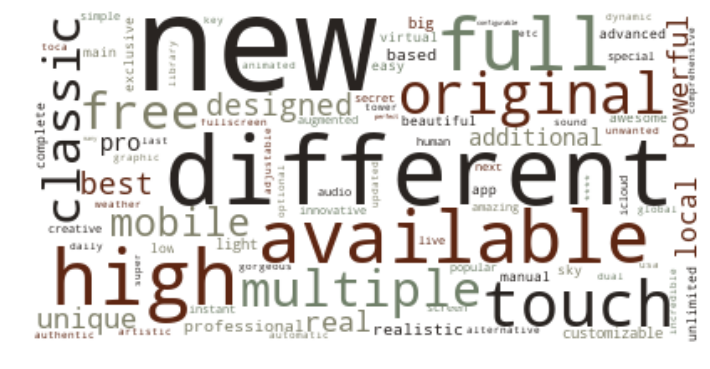

In [10]:
draw_cloud(words_freq)

In [11]:
n_input = ' '.join(apple_subtitle) + ' '.join(apple_title)

In [12]:
r = Rake()
r.extract_keywords_from_text(n_input)
input_freq = r.get_word_frequency_distribution()
words_freq = {key: value for key, value in input_freq.items() if len(key)>2}

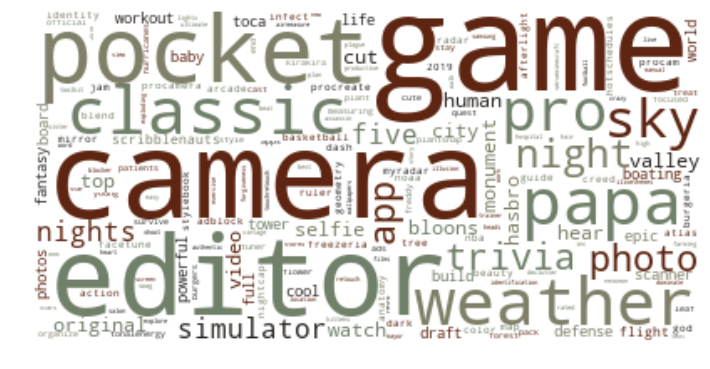

In [13]:
draw_cloud(words_freq)

In [14]:
def get_lda_input(chapters):
    corpus = [" ".join(word_list) for word_list in chapters['subtitle'].tolist()]
    for word_list in chapters['title'].tolist():
        corpus.append(word_list)
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(corpus)
    return X.toarray(), vectorizer

In [15]:
def lda_train(weight, vectorizer, n_topics):
    model = lda.LDA(n_topics=n_topics, n_iter=500, random_state=1)
    model.fit(weight)

    doc_num = len(weight)
    topic_word = model.topic_word_
    vocab = vectorizer.get_feature_names()

    n_top_words = 20
    topics = []
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
        topics.append(' '.join(topic_words))
        
    return topics

In [16]:
category_topic = {}
for cat in apple_grossing['category'].unique():
    cat_apple_grossing = apple_grossing[apple_grossing.category.isin([cat])]
    weight, vectorizer = get_lda_input(cat_apple_grossing)
    topic = lda_train(weight, vectorizer, 1)
    category_topic[cat] = topic[0]

INFO:lda:n_documents: 70
INFO:lda:vocab_size: 73
INFO:lda:n_words: 99
INFO:lda:n_topics: 1
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -685
INFO:lda:<10> log likelihood: -685
INFO:lda:<20> log likelihood: -685
INFO:lda:<30> log likelihood: -685
INFO:lda:<40> log likelihood: -685
INFO:lda:<50> log likelihood: -685
INFO:lda:<60> log likelihood: -685
INFO:lda:<70> log likelihood: -685
INFO:lda:<80> log likelihood: -685
INFO:lda:<90> log likelihood: -685
INFO:lda:<100> log likelihood: -685
INFO:lda:<110> log likelihood: -685
INFO:lda:<120> log likelihood: -685
INFO:lda:<130> log likelihood: -685
INFO:lda:<140> log likelihood: -685
INFO:lda:<150> log likelihood: -685
INFO:lda:<160> log likelihood: -685
INFO:lda:<170> log likelihood: -685
INFO:lda:<180> log likelihood: -685
INFO:lda:<190> log likelihood: -685
INFO:lda:<200> log likelihood: -685
INFO:lda:<210> log likelihood: -685
INFO:lda:<220> log likelihood: -685
INFO:lda:<230> log likelihood: -685
INFO:lda:<240> log likelihood: -685

INFO:lda:<60> log likelihood: -5
INFO:lda:<70> log likelihood: -5
INFO:lda:<80> log likelihood: -5
INFO:lda:<90> log likelihood: -5
INFO:lda:<100> log likelihood: -5
INFO:lda:<110> log likelihood: -5
INFO:lda:<120> log likelihood: -5
INFO:lda:<130> log likelihood: -5
INFO:lda:<140> log likelihood: -5
INFO:lda:<150> log likelihood: -5
INFO:lda:<160> log likelihood: -5
INFO:lda:<170> log likelihood: -5
INFO:lda:<180> log likelihood: -5
INFO:lda:<190> log likelihood: -5
INFO:lda:<200> log likelihood: -5
INFO:lda:<210> log likelihood: -5
INFO:lda:<220> log likelihood: -5
INFO:lda:<230> log likelihood: -5
INFO:lda:<240> log likelihood: -5
INFO:lda:<250> log likelihood: -5
INFO:lda:<260> log likelihood: -5
INFO:lda:<270> log likelihood: -5
INFO:lda:<280> log likelihood: -5
INFO:lda:<290> log likelihood: -5
INFO:lda:<300> log likelihood: -5
INFO:lda:<310> log likelihood: -5
INFO:lda:<320> log likelihood: -5
INFO:lda:<330> log likelihood: -5
INFO:lda:<340> log likelihood: -5
INFO:lda:<350> log

INFO:lda:<190> log likelihood: -66
INFO:lda:<200> log likelihood: -66
INFO:lda:<210> log likelihood: -66
INFO:lda:<220> log likelihood: -66
INFO:lda:<230> log likelihood: -66
INFO:lda:<240> log likelihood: -66
INFO:lda:<250> log likelihood: -66
INFO:lda:<260> log likelihood: -66
INFO:lda:<270> log likelihood: -66
INFO:lda:<280> log likelihood: -66
INFO:lda:<290> log likelihood: -66
INFO:lda:<300> log likelihood: -66
INFO:lda:<310> log likelihood: -66
INFO:lda:<320> log likelihood: -66
INFO:lda:<330> log likelihood: -66
INFO:lda:<340> log likelihood: -66
INFO:lda:<350> log likelihood: -66
INFO:lda:<360> log likelihood: -66
INFO:lda:<370> log likelihood: -66
INFO:lda:<380> log likelihood: -66
INFO:lda:<390> log likelihood: -66
INFO:lda:<400> log likelihood: -66
INFO:lda:<410> log likelihood: -66
INFO:lda:<420> log likelihood: -66
INFO:lda:<430> log likelihood: -66
INFO:lda:<440> log likelihood: -66
INFO:lda:<450> log likelihood: -66
INFO:lda:<460> log likelihood: -66
INFO:lda:<470> log l

INFO:lda:<320> log likelihood: -23
INFO:lda:<330> log likelihood: -23
INFO:lda:<340> log likelihood: -23
INFO:lda:<350> log likelihood: -23
INFO:lda:<360> log likelihood: -23
INFO:lda:<370> log likelihood: -23
INFO:lda:<380> log likelihood: -23
INFO:lda:<390> log likelihood: -23
INFO:lda:<400> log likelihood: -23
INFO:lda:<410> log likelihood: -23
INFO:lda:<420> log likelihood: -23
INFO:lda:<430> log likelihood: -23
INFO:lda:<440> log likelihood: -23
INFO:lda:<450> log likelihood: -23
INFO:lda:<460> log likelihood: -23
INFO:lda:<470> log likelihood: -23
INFO:lda:<480> log likelihood: -23
INFO:lda:<490> log likelihood: -23
INFO:lda:<499> log likelihood: -23
INFO:lda:n_documents: 2
INFO:lda:vocab_size: 1
INFO:lda:n_words: 1
INFO:lda:n_topics: 1
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: 0
INFO:lda:<10> log likelihood: 0
INFO:lda:<20> log likelihood: 0
INFO:lda:<30> log likelihood: 0
INFO:lda:<40> log likelihood: 0
INFO:lda:<50> log likelihood: 0
INFO:lda:<60> log likelihood: 0
INF

In [17]:
for key in category_topic:
    print (str(key)+':')
    print (category_topic[key])

Games:
papa to go five nights at freddy monument scribblenauts simulator game the td bloons valley classic flight flick where freezeria
Education:
toca walk star sky salon plantsnap plant night map life identification hospital hair
Medical:
my human heartbeat hear baby atlas app anatomy 2019
Photo & Video:
camera word vintage afterlight cool cut cute facetune fonts for glitché kirakira lightx mirror nightcap pro procam procamera samsung superimpose
Reference:
sky guide
Weather:
weather sky radar pro noaa myradar dark carrot
Business:
scanner pro hotschedules
Productivity:
stay forest focused
Health & Fitness:
workout watch trainer tracker minute full for fitness exercise challenge autosleep
Sports:
football fantasy draft 2018
Music:
tuner tonalenergy studio mobile metronome fl
Entertainment:
pocket procreate os ilivethemes god dokk
Utilities:
tape ruler ar airmeasure adblock
Lifestyle:
stylebook
Navigation:
usa boating


In [18]:
corpus = []
for cat in apple_grossing['category'].unique():
    cat_apple_grossing = apple_grossing[apple_grossing.category.isin([cat])]
    raw_text = " ".join(cat_apple_grossing['subtitle'].tolist()) + " ".join(cat_apple_grossing['title'].tolist())
    corpus.append(raw_text)

In [19]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
weight = X.toarray()

In [20]:
model = lda.LDA(n_topics=20, n_iter=500, random_state=1)
model.fit(weight)

doc_num = len(weight)
topic_word = model.topic_word_
vocab = vectorizer.get_feature_names()
titles = apple_grossing['category'].unique()

n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

INFO:lda:n_documents: 15
INFO:lda:vocab_size: 293
INFO:lda:n_words: 415
INFO:lda:n_topics: 20
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -4394
INFO:lda:<10> log likelihood: -3295
INFO:lda:<20> log likelihood: -3321
INFO:lda:<30> log likelihood: -3315
INFO:lda:<40> log likelihood: -3319
INFO:lda:<50> log likelihood: -3309
INFO:lda:<60> log likelihood: -3299
INFO:lda:<70> log likelihood: -3272
INFO:lda:<80> log likelihood: -3374
INFO:lda:<90> log likelihood: -3320
INFO:lda:<100> log likelihood: -3299
INFO:lda:<110> log likelihood: -3325
INFO:lda:<120> log likelihood: -3267
INFO:lda:<130> log likelihood: -3317
INFO:lda:<140> log likelihood: -3294
INFO:lda:<150> log likelihood: -3277
INFO:lda:<160> log likelihood: -3278
INFO:lda:<170> log likelihood: -3278
INFO:lda:<180> log likelihood: -3313
INFO:lda:<190> log likelihood: -3237
INFO:lda:<200> log likelihood: -3308
INFO:lda:<210> log likelihood: -3321
INFO:lda:<220> log likelihood: -3274
INFO:lda:<230> log likelihood: -3313
INFO:lda

Topic 0: tonalenergy mobile tools studio pocket fl powerful tuner no practice
Topic 1: td hear baby my infinite beathuman heart atlas as live
Topic 2: to trivia of epic city game the own geometry flick
Topic 3: build world top home survive for by plague story basketball
Topic 4: your scanner studyforest burgeria declutter end focused fonts infect lightx
Topic 5: weather app body complete usa appboating myradar anatomy plant crazy
Topic 6: editor photo retouch glitch touchretouch authentic procam vhs raw screen
Topic 7: night or style guide identify old afterlight constellation map wild
Topic 8: photos video light shoot swag pictures blend camerafacetune nightcap vintage
Topic 9: run quiz text glitché play stream cast heartbeat boating view
Topic 10: defense location adventure serve create challenge flower stylebook best be
Topic 11: watch workout full exercise for with sleep auto minute fitness
Topic 12: pro toca sky noaa color powerful ar hospital human tree
Topic 13: camera selfie or

In [21]:
def plot_topic(doc_topic):
    f, ax = plt.subplots(figsize=(10, 6))
    cmap = sns.cubehelix_palette(start=1, rot=3, gamma=0.8, as_cmap=True)
    sns.heatmap(doc_topic, cmap=cmap, linewidths=0.05, ax=ax)
    ax.set_title('proportion per topic in every category')
    ax.set_xlabel('topic')
    ax.set_ylabel('category')
    plt.show()

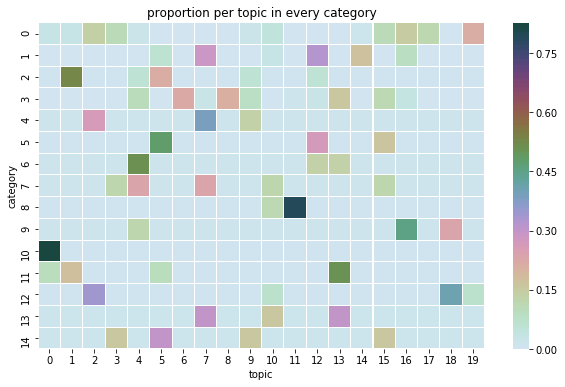

In [22]:
doc_topic = model.doc_topic_
plot_topic(doc_topic)

In [23]:
for i in range(doc_num):
    print("{} (top topic: {})".format(titles[i], np.argsort(doc_topic[i])[:-4:-1]))

Games (top topic: [19 16  2])
Education (top topic: [12  7 14])
Medical (top topic: [1 5 9])
Photo & Video (top topic: [ 6  8 13])
Reference (top topic: [7 2 9])
Weather (top topic: [ 5 12 15])
Business (top topic: [ 4 13 12])
Productivity (top topic: [ 4  7 15])
Health & Fitness (top topic: [11 10 19])
Sports (top topic: [16 18  4])
Music (top topic: [ 0 18  1])
Entertainment (top topic: [13  1  0])
Utilities (top topic: [18  2 19])
Lifestyle (top topic: [13  7 10])
Navigation (top topic: [ 5  9 15])
